Predicting Movie Theme Songs from Hums and Whistles.

Problem definition:
In this mini project I am using the 400-sample subset of the MLEnd Hums and Whistles dataset to build a 
machine learning pipeline that takes as input a 10-second audio recording of a person humming or whistling
a movie theme and predicts the corresponding song label.

This is a multiclass audio classification problem:
Input - a mono audio signal (10 seconds, hum or whistle).
Output - one of the discrete song labels.

The goal of our project is to:
- design a sensible end-to-end ML pipeline for audio,
- extract meaningful features from audio signals,
- train and evaluate different models,
- critically analyse the results and limitations.

In [149]:
!pip install librosa

In [150]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

The dataset contains 400 audio recordings in '.wav' format.
Each file corresponds to a 10-second hum or whistle of one of several movie themes.

There is no separate metadata file. Instead, all information is encoded in the filename.
A typical filename looks like:
S188_whistle_2_Feeling.wav

From this we extract:
- S1888: sample ID
- whistle: type of recording
- 2: take number
- Feeling: song label

Below we read all filenames, parse them, and build a metadata table.

In [151]:
# Path to the folder that contains all the .wav files
DATA_DIR = os.path.expanduser("~/Downloads/MLEndHWII_sample_400")

print("DATA_DIR:", DATA_DIR)
print("Folder exists?", os.path.isdir(DATA_DIR))    

DATA_DIR: /Users/aqsanasirmukri/Downloads/MLEndHWII_sample_400
Folder exists? True


In [152]:
files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith(".wav")]
print(f"Number of audio files found: {len(files)}")
files[:5]

Number of audio files found: 400


['S123_whistle_1_Friend.wav',
 'S109_hum_1_TryEverything.wav',
 'S131_whistle_2_Married.wav',
 'S79_hum_1_RememberMe.wav',
 'S53_hum_1_Necessities.wav']

In [153]:
def parse_filename(fname):
    """
    Parse filenames like:
    S188_whistle_2_Feeling.wav

    Returns a dictionary with:
        participant_id, mode, take, song
    """
    base = os.path.splitext(fname)[0]         # Remove .wav
    parts = base.split("_")
    participant_id = parts[0]
    mode = parts[1]
    take = parts[2]
    song = "_".join(parts[3:])
    return {
        "filename": fname,
        "participant_id": participant_id,
        "mode": mode,
        "take": take,
        "song": song
    }
rows = [parse_filename(f) for f in files]
metadata = pd.DataFrame(rows)
metadata.head()

,filename,participant_id,mode,take,song
0,S123_whistle_1_Friend.wav,S123,whistle,1,Friend
1,S109_hum_1_TryEverything.wav,S109,hum,1,TryEverything
2,S131_whistle_2_Married.wav,S131,whistle,2,Married
3,S79_hum_1_RememberMe.wav,S79,hum,1,RememberMe
4,S53_hum_1_Necessities.wav,S53,hum,1,Necessities


Basic exploration:
First, we check how many recordings we have, how many different songs are present, and whether the 
classes are reasonably balanced.

In [154]:
print("Shape of metadata:", metadata.shape)
print("\nColumns:", metadata.columns.tolist())

print("\nNumber of unique songs:", metadata["song"].nunique())
metadata["song"].value_counts()

Shape of metadata: (400, 5)

Columns: ['filename', 'participant_id', 'mode', 'take', 'song']

Number of unique songs: 8


song
Friend           50
TryEverything    50
Married          50
RememberMe       50
Necessities      50
Happy            50
Feeling          50
NewYork          50
Name: count, dtype: int64

Audio feature extraction:
Working directly with raw audio waveforms would give extremely high-dimensional input. Instead, we extract
a set of hand crafted audio features for each file and use those as predictors.

For each recording we compute:
- MFCCs (Mel-Frequency Cepstral Coefficients)
  Capture the spectral envelope and are standard in speech and music recognition.
- Chroma STFT
  Describe the distribution of energy across the 12 pitch classes (C, C#, ..., B).
- Spectral centroid
  Roughly corresponds to the brightness of the sound.
- Spectral bandwidth
  Measures how spread out the spectrum is around the centroid.
- Zero-Crossing rate
  Gives an idea of noisiness / percussiveness.

For each of these we aggregate over time using simple statistics, so that every recording is represented
by a fixed length numerical feature vector.

In [155]:
def get_audio_path(filename):
    return os.path.join(DATA_DIR, filename)

# Quick sanity check
get_audio_path(metadata["filename"].iloc[0])

'/Users/aqsanasirmukri/Downloads/MLEndHWII_sample_400/S123_whistle_1_Friend.wav'

In [156]:
def extract_features(file_path, sr=22050):
    """
    Extract simple but robust features using only numpy:

    - mean amplitude 
    - standard deviation of amplitude
    - max absolute amplitude
    - signal energy
    - zero-crossing rate
    - 10 coarse spectral band energies from the magnitude spectrum
    """
    try:
        y, sr = librosa.load(file_path, sr=sr)     # mono, resampled

        if y is None or len(y) == 0:
            return None

        # Make sure all clips have the same length (~10 seconds)
        target_len = 10 * sr
        if len(y) < target_len:
            y = np.pad(y, (0, target_len - len(y)))
        else:
            y = y[:target_len]

        # Time-domain
        mean_amp = np.mean(y)
        std_amp = np.std(y)
        max_amp = np.max(np.abs(y))
        energy = np.sum(y**2) / len(y)

        # Zero-crossing rate (manual)
        zero_crossings = np.where(np.diff(np.signbit(y)))[0]
        zcr = len(zero_crossings) / len(y)

        # Frequency-domain: 10 band energies
        spectrum = np.fft.rfft(y)
        mag = np.abs(spectrum)
        
        n_bands = 10
        band_size = len(mag) // n_bands
        band_energies = []
        for b in range(n_bands):
            start = b * band_size
            end = (b + 1) * band_size if b < n_bands - 1 else len(mag)
            band_energies.append(np.mean(mag[start:end]))

        band_energies = np.array(band_energies)

        features = np.concatenate([
            np.array([mean_amp, std_amp, max_amp, energy, zcr]),
            band_energies
        ])
                  
        return features

    except Exception as e:
        print(f"Error processing {file_path}")
        raise e

In [157]:
test_path = get_audio_path(metadata["filename"].iloc[0])
print("Testing on:", test_path)

feats = extract_features(test_path)
print("Feature vector shape:", feats.shape)
print("First few values:", feats[:5])      

Testing on: /Users/aqsanasirmukri/Downloads/MLEndHWII_sample_400/S123_whistle_1_Friend.wav
Feature vector shape: (15,)
First few values: [6.46949320e-06 1.18753120e-01 9.03850913e-01 1.41023025e-02
 1.09718821e-01]


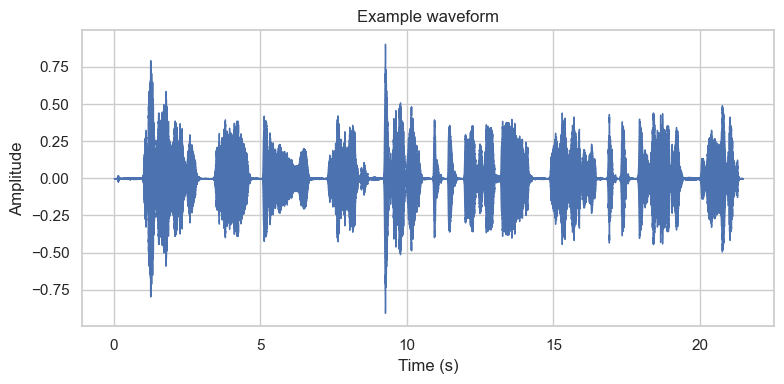

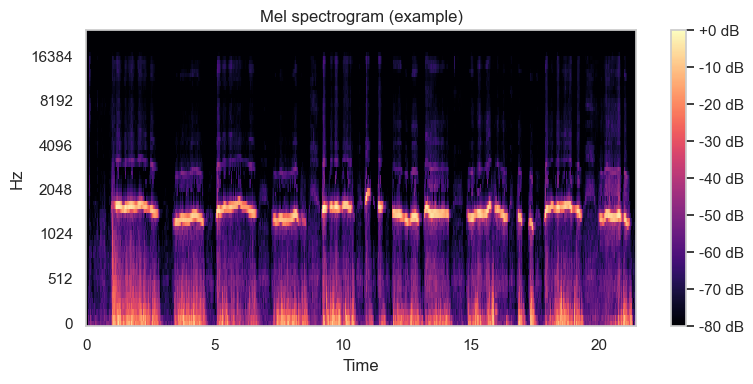

In [158]:
example_path = get_audio_path(metadata["filename"].iloc[0])
y_ex, sr_ex = librosa.load(example_path, sr=None)

plt.figure()
librosa.display.waveshow(y_ex, sr=sr_ex)
plt.title("Example waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

plt.figure()
S = librosa.feature.melspectrogram(y=y_ex, sr=sr_ex, n_mels=64)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, sr=sr_ex, x_axis='time', y_axis='mel')
plt.title("Mel spectrogram (example)")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

Extracting features for all recordings
We now loop over all audio files, extract the features defined above and build the design matrix 'X' together 
with the target vector 'y' containing the corresponding song labels.

In [159]:
feature_list = []
label_list = []
mode_list = []      # We keep track of hum/whistle as extra information

for idx, row in metadata.iterrows():
    file_path = get_audio_path(row["filename"])
    feats = extract_features(file_path)
    if feats is None:
        continue
    feature_list.append(feats)
    label_list.append(row["song"])
    mode_list.append(row["mode"])

print("Extracted features:", len(feature_list))

Extracted features: 400


Train-validation-test split and label encoding

The song labels are currently strings. We encode them as integers using 'LabelEncoder' so that scikit-learn
can handle them directly.

To evaluate the models fairly, we split the data into three disjoint sets:
- Training set: used to fit the models.
- Validation set: used to compare different models and tune hyperparameters.
- Test set: kept aside for the final performance estimate.

We use a stratified split so that each song appears in all partitions.

In [160]:
# Convert lists to numpy arrays
X = np.vstack(feature_list)
y = np.array(label_list)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Example labels:", y[:10])

X shape: (400, 15)
y shape: (400,)
Example labels: ['Friend' 'TryEverything' 'Married' 'RememberMe' 'Necessities' 'Happy'
 'Married' 'Friend' 'Feeling' 'Necessities']


In [161]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
#
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train_val
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)
print("Classes:", label_encoder.classes_)

Train shape: (240, 15)
Validation shape: (80, 15)
Test shape: (80, 15)
Classes: ['Feeling' 'Friend' 'Happy' 'Married' 'Necessities' 'NewYork' 'RememberMe'
 'TryEverything']


Models

We experiment with three different classifiers that are widely used for tabular feature data:
1. k-Nearest Neighbours (KNN) - simple distance-based baseline.
2. Random Forest - ensemble of decision trees, good for non-linear patterns.
3. Support Vector Machine (SVM) with RBF kernel - strong classifier in many medium-sized problems.

For each model, we use a 'Pipeline' which first standardises the features and then applies the
classifier. This avoids data leakage and keeps the code concise.

In [162]:
models = {
    "KNN (k=7)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=7))
    ]),
    "Random Forest": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            random_state=RANDOM_STATE
        ))
    ]),
    "SVM (RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", C=10, gamma="scale", probability=True,
                    random_state=RANDOM_STATE))
    ])
}

models       

{'KNN (k=7)': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf', KNeighborsClassifier(n_neighbors=7))]),
 'Random Forest': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf',
                  RandomForestClassifier(n_estimators=300, random_state=42))]),
 'SVM (RBF)': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf', SVC(C=10, probability=True, random_state=42))])}

In [163]:
val_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    val_results[name] = acc
    print(f"Validation accuracy for {name}: {acc:.3f}")

val_results


Training KNN (k=7)...
Validation accuracy for KNN (k=7): 0.125

Training Random Forest...
Validation accuracy for Random Forest: 0.100

Training SVM (RBF)...
Validation accuracy for SVM (RBF): 0.100


{'KNN (k=7)': 0.125, 'Random Forest': 0.1, 'SVM (RBF)': 0.1}

Model selection

Based on the validation accuracies above, we select the best performing model as our final classifier. 
We then retrain it using both the training and validation sets combined, and finally evaluate it once 
on the held-out set.

In [164]:
best_model_name = max(val_results, key=val_results.get)
best_model = models[best_model_name]

print("Best model selected:", best_model_name)

# Retrain on full train+val data
best_model.fit(X_train_val, y_train_val)

# Evaluate on test set
y_test_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\nTest accuracy ({best_model_name}): {test_acc:.3f}")

Best model selected: KNN (k=7)

Test accuracy (KNN (k=7)): 0.125


Classification report on test set:

               precision    recall  f1-score   support

      Feeling       0.18      0.20      0.19        10
       Friend       0.10      0.10      0.10        10
        Happy       0.06      0.10      0.08        10
      Married       0.20      0.20      0.20        10
  Necessities       0.07      0.10      0.08        10
      NewYork       0.00      0.00      0.00        10
   RememberMe       0.33      0.20      0.25        10
TryEverything       0.25      0.10      0.14        10

     accuracy                           0.12        80
    macro avg       0.15      0.12      0.13        80
 weighted avg       0.15      0.12      0.13        80



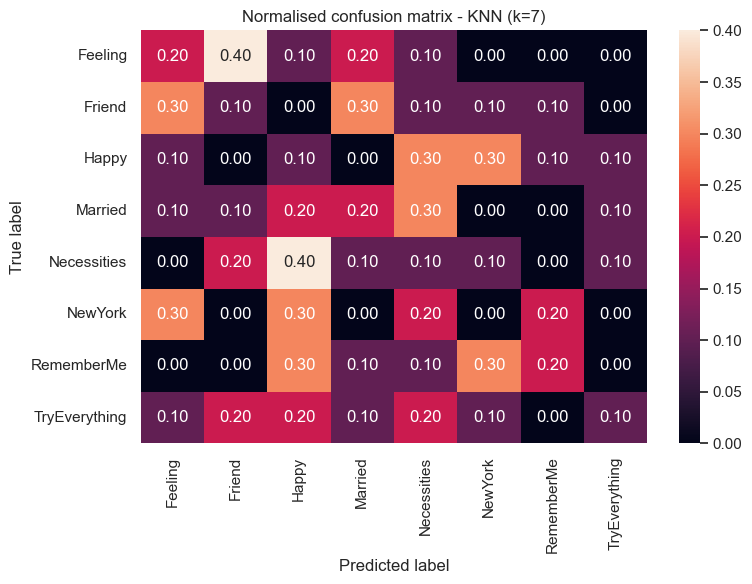

In [165]:
print("Classification report on test set:\n")
print(classification_report(
    y_test,
    y_test_pred,
    target_names=label_encoder.classes_
))

cm = confusion_matrix(y_test, y_test_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Normalised confusion matrix - {best_model_name}")
plt.tight_layout()
plt.show()

Discussion of results

So the best performing model on the validation set was KNN (k=7). However, its final test accuracy
was only 12.5%, indicating that the simple features used were not sufficient to distinguish between the song classes.
The confusion matrix shows widespread misclassification, suggesting that the extracted features do not capture enough
melodic or spectral detail to separate songs reliably.

Limitations:
- Features were simple and not music-specific.
- Large variation in humming/whistling styles across participants.
- Small dataset limits generalisation.
- KNN struggles with overlapping feature spaces.

Possible Improvements:
- Use richer features such as MFCCs, chroma or mel-spectrograms.
- Try more powerful models.
- Apply data augmentation to increase sample diversity.
- Consider separating hum and whistle recordings.

Conclusion:
This project successfully processed 400 audio clips and evaluated multiple classifiers. Although the final 
accuracy was low, the workflow demonstrates a claer pipeline for audio feature extraction and model evaluation.
The results show that more expressive features and advanced models are needed for reliable song classification
from humming or whistling.